In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import glob
import os
from tqdm import tqdm

In [11]:
data_dir = '../data/room2'
processed_dir = '../data/room_processed'
for img_path in tqdm(os.listdir(data_dir)):
    img = cv2.imread(os.path.join(data_dir, img_path))
    blur_img = cv2.GaussianBlur(img, (21, 21), 0)
    small_img = cv2.resize(blur_img, (0, 0), fx=0.5, fy=0.5)
    cv2.imwrite(os.path.join(processed_dir, img_path), small_img)

100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


100%|██████████| 12/12 [00:00<00:00, 61.91it/s]


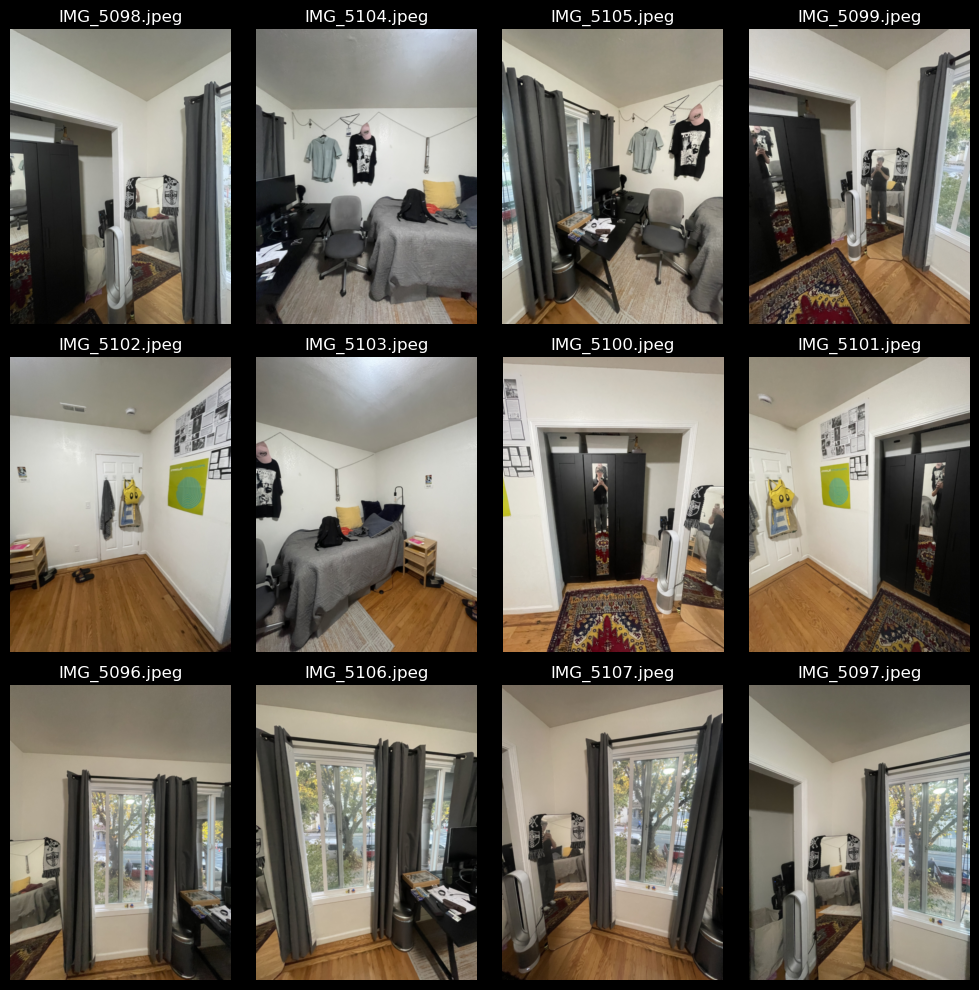

In [17]:
# plot images
fig, axs = plt.subplots(3, 4, figsize=(10, 10))
for i, img_path in enumerate(tqdm(os.listdir(processed_dir))):
    img = cv2.imread(os.path.join(processed_dir, img_path))
    axs[i//4, i%4].set_title(img_path)
    axs[i//4, i%4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()


# stitching images

In [19]:
# using opencv to stitch images
def stitch_images(images):
    stitcher = cv2.Stitcher_create()
    status, stitched = stitcher.stitch(images)
    if status == cv2.Stitcher_OK:
        print("Stitching completed successfully.")
        return stitched
    else:
        print(f"Stitching failed with error code {status}")
        return None


In [12]:
def detect_and_compute(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=2000)
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    return keypoints, descriptors

def match_features(desc1, desc2):
    # Initialize the Brute-Force matcher with Hamming distance (for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Perform matching
    matches = bf.match(desc1, desc2)
    
    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)
    
    return matches

def estimate_homography(kp1, kp2, matches):
    if len(matches) < 4:
        raise ValueError("Not enough matches to compute homography.")
    
    # Extract matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Compute homography using RANSAC to handle outliers
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    return H, mask

def warp_images(image1, image2, H):
    # Get image dimensions
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    
    # Get the canvas dimensions
    # Corners of image2
    corners_image2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    # Transform corners of image2 onto image1's plane
    warped_corners = cv2.perspectiveTransform(corners_image2, H)
    
    # Combine corners to get the size of the output image
    all_corners = np.concatenate((np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2), warped_corners), axis=0)
    
    # Find the min and max coordinates
    [xmin, ymin] = np.int32(all_corners.min(axis=0).flatten() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).flatten() + 0.5)
    
    # Translation to shift the panorama
    translation_dist = [-xmin, -ymin]
    translation_matrix = np.array([[1, 0, translation_dist[0]],
                                   [0, 1, translation_dist[1]],
                                   [0, 0, 1]])
    
    # Warp image2
    output_size = (xmax - xmin, ymax - ymin)
    warped_image2 = cv2.warpPerspective(image2, translation_matrix.dot(H), output_size)
    
    # Paste image1 onto the panorama
    panorama = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    panorama[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = image1
    
    return panorama, warped_image2, translation_dist

def blend_images(panorama, warped_image, translation_dist):
    # Create a mask for the overlapping area
    overlap_mask = (panorama > 0) & (warped_image > 0)
    
    # Average the overlapping regions
    panorama[overlap_mask] = panorama[overlap_mask] // 2 + warped_image[overlap_mask] // 2
    
    # Add non-overlapping regions
    panorama[~(panorama > 0)] = warped_image[~(panorama > 0)]
    
    return panorama


def stitch_pair(image1, image2):
    # Step 1: Feature detection and description
    kp1, desc1 = detect_and_compute(image1)
    kp2, desc2 = detect_and_compute(image2)
    
    # Step 2: Feature matching
    matches = match_features(desc1, desc2)
    
    # Step 3: Homography estimation
    H, mask = estimate_homography(kp1, kp2, matches)
    
    # Step 4: Image warping
    panorama, warped_image2, translation_dist = warp_images(image1, image2, H)
    
    # Step 5: Image blending
    result = blend_images(panorama, warped_image2, translation_dist)
    
    return result

def stitch_images(images):
    if len(images) < 2:
        raise ValueError("Need at least two images to stitch.")
    
    # Start with the first image
    stitched_image = images[0]
    
    for i in range(1, len(images)):
        print(f"Stitching image {i+1} of {len(images)}...")
        stitched_image = stitch_pair(stitched_image, images[i])
    
    return stitched_image


In [21]:
# Load images
image_files = glob.glob('../data/room_processed/*')
images = []
for file in sorted(image_files):
    img = cv2.imread(file)
    if img is not None:
        images.append(img)
# Stitch images
panorama = stitch_images(images)
if panorama is not None:
    cv2.imwrite('panorama.jpg', panorama)
    print("Panorama saved as panorama.jpg")
else:
    print("Failed to create panorama.")

Stitching completed successfully.
Panorama saved as panorama.jpg
